# Quick Start: 単振り子の運動をシミュレーション

<img src="figure/pendulum.png" width="300">

例として， [単振り子](https://ja.wikipedia.org/wiki/%E6%8C%AF%E3%82%8A%E5%AD%90#.E5.8D.98.E6.8C.AF.E3.82.8A.E5.AD.90) の運動をシミュレーションする．

## 0. はじめに

一言に力学シミュレーションといっても，その方法は多様であり，いくつもの方法があるのだが，そのうちの一つを例としてあげる．シミュレーションを行うために必要な作業を

1. ** モデル化 **
2. ** 数値計算 **
3. ** 視覚化 **

の3つのプロセスに分けて考える．

まず，一つ目の「モデル化」について．これは，例えば考える物理モデルからニュートンの運動方程式を導くプロセスのことである．中学の理科，高校の物理，大学の力学などの講義で勉強したのはこの部分である．

次に，二つ目の「数値計算」について．これは，Python プログラムを用いてコンピュータ上で運動を計算させるプロセスのことである．大学の座学の講義ではおそらく詳しくは勉強しない．あるいは，コンピュータを使った演習授業で軽く触れることはあるかもしれないが，その中身をよく吟味する機会はあまりないかもしれない．

最後に，「視覚化」について．「計算」のプロセスでコンピュータは振り子の運動を与えられたモデル情報に基づいて計算し，その結果を数字の羅列で表現している．例えば

> シミュレーション開始0秒後，振り子は10 [rad]の位置にいる
> 
> シミュレーション開始1秒後，振り子は0 [rad]の位置にいる
>
> シミュレーション開始2秒後，振り子は-10 [rad]の位置にいる
>
> シミュレーション開始3秒後，振り子は0 [rad]の位置にいる
>
> ... 

という情報が，

| 時間 | 位置 |  
|:------:|:---------:|
| 0     |  10      |
| 1     | 0     |
| 2     | -10      |
| 3     | 0     |

のような行列となって生成されている．しかし，この数字の羅列だけでは，物体の運動がどのようになっているのかがわからない．そこで，これをグラフにしたりアニメーションにしたりすることで，運動を直感的に理解できるようにする．この部分についても，普通はあまり触れることがないと思う．

## 1. モデル化

<img src="figure/pendulum_model.png" width="300">

図のような，よくある [単振り子の力学モデル](https://ja.wikipedia.org/wiki/%E6%8C%AF%E3%82%8A%E5%AD%90#.E5.8D.98.E6.8C.AF.E3.82.8A.E5.AD.90) を考える．振り子の角度を$\theta$，振り子の長さを$l$，振り子の先端のおもりの質量を$m$，鉛直下向きにはたらく重力の重力加速度を$g$としている．

おもりの運動方向にはたらく力は
\begin{align}
F = -mg\sin\theta
\end{align}
である．おもりの運動方向の加速度は$a = l\ddot{\theta}$なので，ニュートンの運動方程式 ($ma=F$) は，
\begin{align}
m l\ddot{\theta}= -mg\sin\theta \quad \Leftrightarrow \quad \ddot{\theta} = -\frac{g}{l}\sin\theta
\end{align}
である．

さて，単振り子のモデルを考える上で，時間の経過とともに値が変化する　**変数** と，時間の経過に関わらず値が変化しない **定数** が存在した．$\theta$ が前者であり，$m$，$l$，$g$が後者である．** 1. モデル化 ** のプロセスで達成するべきことは，運動方程式を**変数** について整理し，「（変数の時間の微分項）$=$（それ以外の項）」という式を得ることである．

## 2. 数値計算

**1. モデル化** では変数$\theta$についての運動方程式を導いたが， **2. 数値計算** では，これを用いて **常微分方程式** を構築する．

まず，$\theta$自身とその一階微分である$\dot{\theta}$を縦に並べた列ベクトルをつくり，これを$s$とする．
\begin{align}
  s = 
  \begin{bmatrix}
    \theta \\ \dot{\theta}
  \end{bmatrix}
\end{align}
そして，$s$の時間の一階微分を式で表す．ここで，$\ddot{\theta}$は先ほど求めた運動方程式によって，$\ddot{\theta}$を含まない形で表すことができる．
\begin{align}
  \frac{d}{dt} s = 
  \begin{bmatrix}
    \dot{\theta} \\ \ddot{\theta}
  \end{bmatrix} = 
  \begin{bmatrix}
    \dot{\theta} \\ -\frac{g}{l}\sin\theta
  \end{bmatrix}
\end{align}
こうして得られた常微分方程式は，数値計算に適した形となっている．具体的には，$\theta = $ `s[0]` ，$\dot{\theta} = $ `s[1]` とすることで，

```
def odefunc(s, t):
    theta = s[0]
    dtheta = s[1]
    ddtheta = -g/l*sin(theta)
    return np.r_[dtheta, ddtheta]
```
のようにして常微分方程式をPythonの関数として記述したうえで

```
s = odeint(odefunc, s_init, t)
```
を実行することで常微分方程式を数値的に解くことができる．ただし [`odeint`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.odeint.html) は [SciPy](https://www.scipy.org/) ライブラリの `integrate` クラスで定義されている，常微分方程式を解く関数である．

In [31]:
import numpy as np
from scipy.integrate import odeint
from math import sin

''' constants '''
m = 1 # mass of the pendulum
l = 10 # length of the pendulum
g = 10 # Gravitational acceleration

''' time setting '''
t_end = 20 # simulation time
fps = 50 # frame per second. This value means smoothness of produced graph and animation
tstep = 1/fps 
t = np.arange(0, 20, tstep) # 

''' initial value '''
theta_init = 0 # initial value of theta
dtheta_init = 1 # initial value of dot theta
s_init = np.array([theta_init, dtheta_init])

def odefunc(s, t):
    theta = s[0]
    dtheta = s[1]
    ddtheta = -g/l*sin(theta) # <- Equation of motion
    return np.r_[dtheta, ddtheta]

s = odeint(dae, s_init, t)
print('ODE calculation finished.')

ODE calculation finished.


以上が数値計算を行うプログラムである．
```
print(np.c_[t, s])
```
とすることで，

| 時間 | 振子の角度 | 振子の角速度 |  
|:------:|:---------:|:---------:|
| 0.     |  0.      | 1. |
|... | ... | ... |
| 19.98   | -0.246 | 0.969 |

のように，それぞれの時間で振子の角度がどのようになっていて，また振子の角速度がどのようになっているのかを確認することができる．

In [30]:
print(np.c_[t, s])

[[  0.           0.           1.        ]
 [  0.02         0.01999867   0.99980001]
 [  0.04         0.03998935   0.99920022]
 ..., 
 [ 19.94        -0.28501457   0.958809  ]
 [ 19.96        -0.26578339   0.96424771]
 [ 19.98        -0.24644715   0.96931428]]


## 3. 可視化

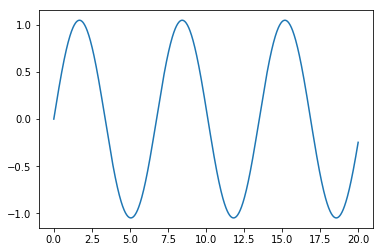

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(t, s[:, 0])